In [6]:
#import some stuff
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import random
import math
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import ipywidgets as widgets
from IPython.display import display
import torch.optim as optim
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def clean_memory():
    gc.collect()           # Garbage collect Python objects
    torch.cuda.empty_cache()  # Clear cached memory on GPU

# the origin of this data seems to be from july
data_dir = "C:/Users/yueze/Desktop/GPT_two_qubit_polarization_tracking/data_2.csv"
df = pd.read_csv(data_dir)
print(df.head)

targets = ["AI0","AI1","AI2"]
features  = ["AI3","AI4","AI5"]
x = df[features]  # Dropping original targets as we'll use aligned targets
y = df[targets]  # Using aligned targets
split_idx = int(len(df) * 0.8)
length_read=len(df)
# Split into training and testing sets
x_train = x.iloc[:split_idx]
y_train = y.iloc[:split_idx]
x_test = x.iloc[split_idx:]
y_test = y.iloc[split_idx:]

input_feature_dim = 3  # Each input element is a 1x3 vector
embed_size = 128
target_dim = 3
block_size = 100
num_heads = 32
max_iters = 1500
batch_size = 32
eval_iters = 200
eval_interval = 10
num_layers=12

def get_batch3(split):
    # Select the correct data split
    if split == 'train':
        a, b, max_index = x_train, y_train, int(length_read * 0.8) - block_size - 1
    else:  # split == 'test'
        a, b, max_index = x_test, y_test, length_read - (int(length_read * 0.8) + block_size + 1)

    # Generate random indices for batch selection, ensuring they're within bounds
    ix = torch.randint(0, max_index, (batch_size,))
    # Initialize lists to hold the batches
    x_batch = []
    y_batch = []

    for i in ix:
        try:
            # Extract sequences from 'a' and 'b' and the corresponding target from 'b'
            seq_A = torch.tensor(a.iloc[i.item():i.item() + block_size].astype(np.float32).values, dtype=torch.float32)
            seq_B = torch.tensor(b.iloc[i.item():i.item()+1].astype(np.float32).values, dtype=torch.float32)
            target = torch.tensor(b.iloc[i.item() + block_size].astype(np.float32).values, dtype=torch.float32)

            seq = torch.cat((seq_A, seq_B), dim=0)
            x_batch.append(seq)
            y_batch.append(target)
        except IndexError as e:
            print(f"IndexError for index {i.item()}: {str(e)}")
            print(f"Attempting to access index [{i.item()}:{i.item() + block_size}] in 'a' with shape {a.shape}")
            print(f"Attempting to access index {i.item() + block_size} in 'b' with shape {b.shape}")
            # Optionally, break or continue depending on desired behavior on error
            break  # or continue

    if not x_batch or not y_batch:
        print("Error: Batch could not be created due to index issues.")
        return None, None

    # Stack the collected sequences and targets into tensors
    xstack = torch.stack(x_batch)
    ystack = torch.stack(y_batch)

    return xstack, ystack


class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, x):
        K = self.keys(x)
        Q = self.queries(x)
        V = self.values(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.embed_size ** 0.5
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.matmul(attention, V)
        return attended

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads

        assert embed_size % num_heads == 0

        self.head_dim = embed_size // num_heads

        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.values = nn.Linear(embed_size, embed_size, bias=False)

        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        keys = self.keys(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        queries = self.queries(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        values = self.values(x).view(batch_size, seq_length, self.num_heads, self.head_dim)

        attention_scores = torch.einsum("bnqh,bnkh->bnqk", [queries, keys]) / (self.head_dim ** 0.5)
        attention = torch.softmax(attention_scores, dim=-1)

        attended = torch.einsum("bnqk,bnkv->bnqv", [attention, values]).reshape(batch_size, seq_length, self.embed_size)

        output = self.fc_out(attended)
        return output

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch3(split)
            X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train
    del X, Y
    return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.dropout1 = nn.Dropout(0.1)

        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, 2 * embed_size),
            nn.ReLU(),
            nn.Linear(2 * embed_size, embed_size),
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, value):
        x = self.norm1(value)
        attention_output = self.attention(x)
        x = value + self.dropout1(attention_output)  # Residual connection and dropout after attention
        x = self.norm2(x)
        feed_forward_output = self.feed_forward(x)
        out = value + self.dropout2(feed_forward_output)  # Residual connection and dropout after FFN
        return out

# Positional Encoding in Encoder class should be moved to the device
class Encoder(nn.Module):
    def __init__(self, input_feature_dim, embed_size, num_heads, num_layers, seq_length):
        super(Encoder, self).__init__()
        self.input_fc = nn.Linear(input_feature_dim, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, embed_size)).to(device)
        self.layers = nn.ModuleList([
            TransformerBlock(embed_size, num_heads) for _ in range(num_layers)])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_fc(x)) + self.positional_encoding
        for layer in self.layers:
            x = layer(x)
        return x
    
    def to_cpu(self):
        # Move the entire model to CPU
        self.input_fc.to('cpu')
        self.positional_encoding.data = self.positional_encoding.data.cpu()
        for layer in self.layers:
            layer.to('cpu')
        self.relu.to('cpu')
        torch.cuda.empty_cache()

class EncoderDecoderModelWithMultiHeadAttention(nn.Module):
    def __init__(self, input_feature_dim, embed_size, target_dim, seq_length, num_heads, num_layers):
        super(EncoderDecoderModelWithMultiHeadAttention, self).__init__()
        self.encoder = Encoder(input_feature_dim, embed_size, num_heads, num_layers, seq_length)
        self.decoder = nn.Sequential(
            nn.Linear(embed_size, target_dim),
        )

    def forward(self, x, targets):
        encoded = self.encoder(x)
        encoded_pooled = torch.mean(encoded, dim=1)
        decoded = self.decoder(encoded_pooled)
        
        if targets is not None:
            loss = criterion(decoded, targets)  
            return decoded, loss

        return decoded, None

    def to_cpu(self):
        self.encoder.to_cpu()
        for layer in self.decoder:
            layer.to('cpu')
        torch.cuda.empty_cache()
    


actuals = []
predictions = []


<bound method NDFrame.head of             TimeStamps       AI0       AI1       AI2       AI3       AI4  \
0             0.000000  0.930403 -1.619047 -1.648352 -1.306471  1.995116   
1             0.101598  0.989011 -1.589744 -1.638583 -1.277167  2.024420   
2             0.201083  0.959707 -1.599511 -1.667888 -1.257631  2.034188   
3             0.301012  0.940171 -1.628816 -1.648352 -1.218559  2.043956   
4             0.400344  0.969475 -1.579975 -1.609280 -1.277167  1.995116   
...                ...       ...       ...       ...       ...       ...   
1736731  173673.101183 -1.853479 -1.316239  0.881563 -1.775335  1.692307   
1736732  173673.201641 -1.833943 -1.208791  0.862027 -1.785104  1.663004   
1736733  173673.301680 -1.892551 -1.247863  0.930403 -1.833943  1.604396   
1736734  173673.400855 -1.902320 -1.208791  0.949939 -1.853479  1.614163   
1736735  173673.501030 -1.863248 -1.277167  0.989011 -1.824176  1.663004   

              AI5  
0       -0.612943  
1       -0.564102

In [7]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size+1, num_heads, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for iter in range(max_iters):
        # Evaluate the loss periodically
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch3('train')
        xb, yb = xb.to(device), yb.to(device)  # Ensure these tensors are on the correct device

        predictions, loss = model(xb, yb)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
                # After using tensors in a training step
        del xb, yb, predictions  # Assuming these are not needed after the training step
        clean_memory()  # Call this to clear memoryq
    print("Loss:", loss.item())
    del loss  # Assuming these are not needed after the training step
    clean_memory()  # Call this to clear memoryq
    model.to_cpu()
    # Save the model
    model_path = "C:/Users/yueze/Desktop/trained_model.pth"
    torch.save(model, model_path)

    print("Model saved to", model_path)
    
    # To load the model later
    # model = EncoderDecoderModelWithMultiHeadAttention(input_feature_dim, embed_size, target_dim, block_size*2+2, num_heads, num_layers)
    # model.load_state_dict(torch.load(model_path, map_location=device))
    # model.to(device)
    # print("Model loaded from", model_path)

step 0: train loss 2.6092, val loss 2.7073
step 10: train loss 0.9711, val loss 2.1277
step 20: train loss 0.8506, val loss 1.5244
step 30: train loss 0.6596, val loss 2.4346
step 40: train loss 0.6226, val loss 2.2652
step 50: train loss 0.6342, val loss 2.7755
step 60: train loss 0.5908, val loss 2.2830
step 70: train loss 0.6197, val loss 2.7960
step 80: train loss 0.6760, val loss 1.6098
step 90: train loss 0.5350, val loss 1.9335
step 100: train loss 0.5566, val loss 1.9478
step 110: train loss 0.5327, val loss 2.0204
step 120: train loss 0.4866, val loss 2.2009
step 130: train loss 0.4852, val loss 2.4222
step 140: train loss 0.5368, val loss 1.8890
step 150: train loss 0.4499, val loss 2.3242
step 160: train loss 0.4445, val loss 2.0023
step 170: train loss 0.4494, val loss 2.3993
step 180: train loss 0.4342, val loss 1.9544
step 190: train loss 0.4129, val loss 2.2176
step 200: train loss 0.3844, val loss 2.2337
step 210: train loss 0.3936, val loss 2.0581
step 220: train loss 

In [8]:
def prepare_full_dataset(x, y, block_size,length):
    full_sequences = []
    for i in range(length - block_size + 1):
        seq = torch.tensor(x.iloc[i:i + block_size].astype(np.float32).values)
        seq2 = torch.tensor(y.iloc[i:i + 1].astype(np.float32).values)
        combined_seq = torch.cat((seq, seq2), dim=0)
        full_sequences.append(combined_seq)
    
    full_dataset = torch.stack(full_sequences)
    return full_dataset

# Prepare the full dataset and send it to the correct device
x_full = prepare_full_dataset(df[features],df[targets], block_size,500000)

In [15]:
batch_size = 1000
num_samples = x_full.size(0)  # Get the total number of samples
all_predictions = []

model.to_cpu()  # Ensure the model is on the CPU

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)  # Calculate the end index of the batch
        batch_x = x_full[start_idx:end_idx]  # Extract the batch
        predictions_batch, _ = model(batch_x, None)  # Get predictions for the batch
        all_predictions.append(predictions_batch.cpu())  # Collect the predictions

# Concatenate all batch predictions into a single tensor
predictions_full = torch.cat(all_predictions, dim=0)

In [16]:
AI0 = predictions_full[:, 0].numpy()
AI1 = predictions_full[:, 1].numpy()
AI2 = predictions_full[:, 2].numpy()

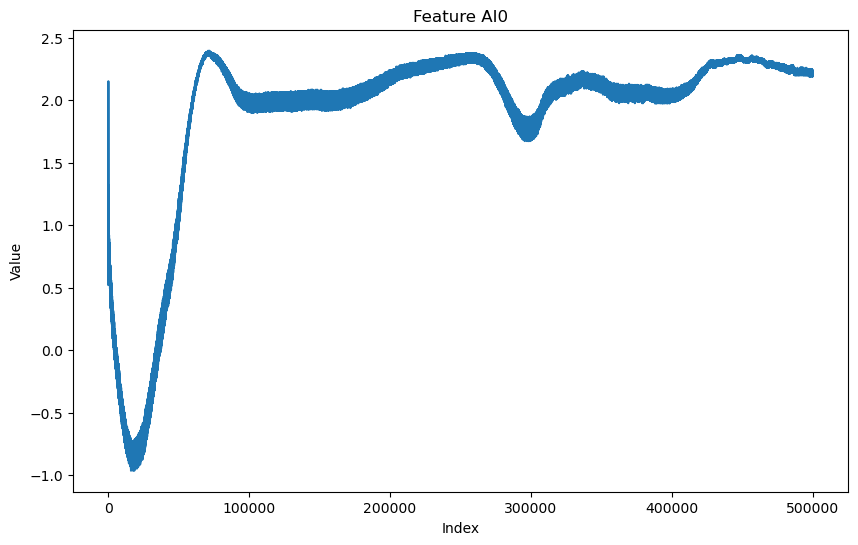

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df["AI0"][0:500000])
plt.title('Feature AI0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

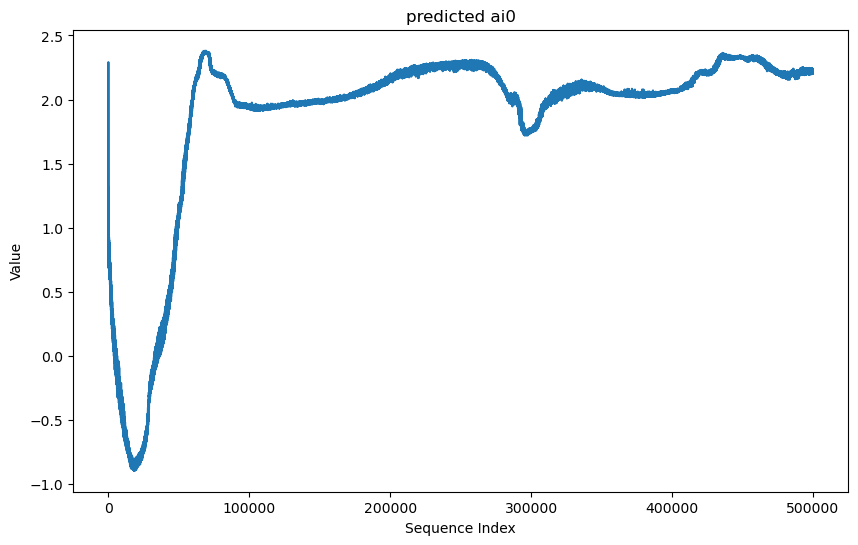

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(AI0)
plt.title('predicted ai0')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()

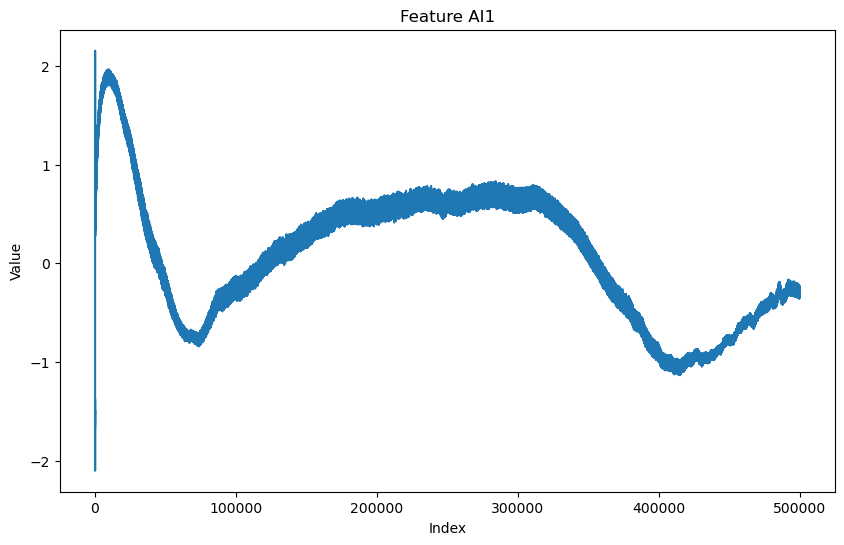

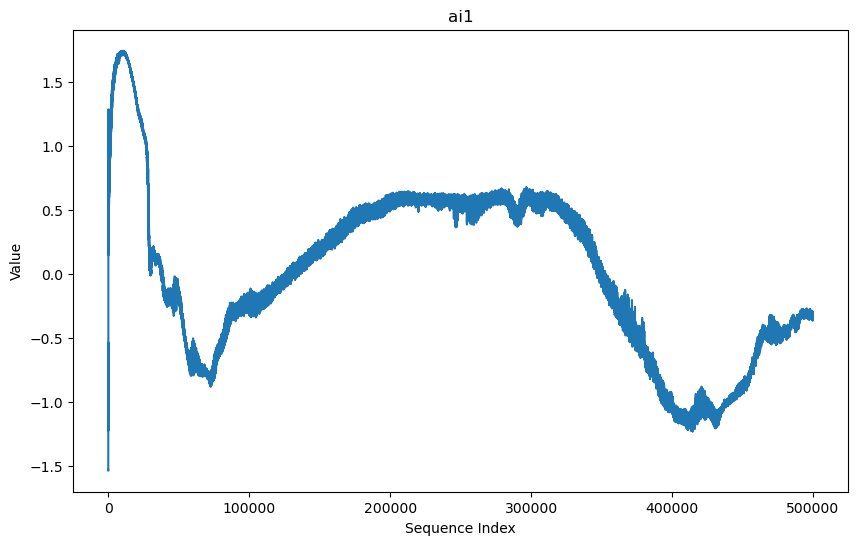

In [22]:

plt.figure(figsize=(10, 6))
plt.plot(df["AI1"][0:500000])
plt.title('Feature AI1')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(AI1)
plt.title('ai1')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()

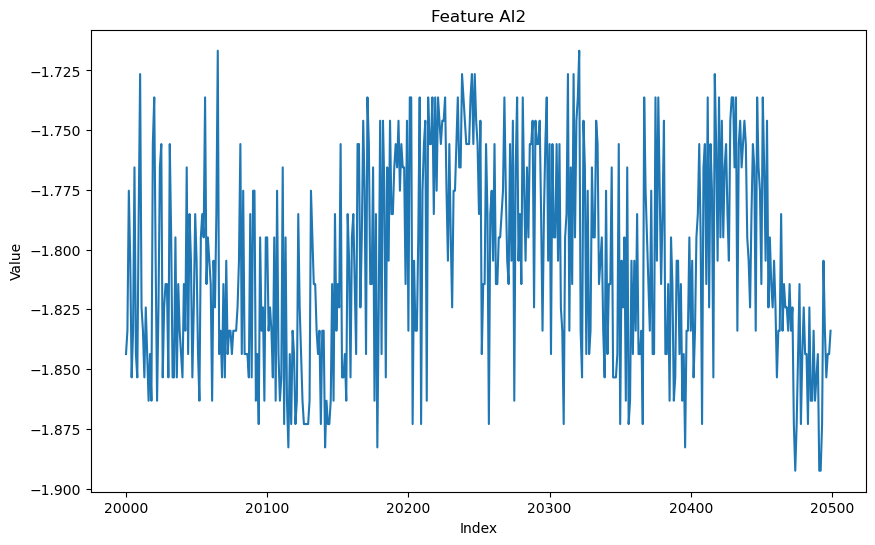

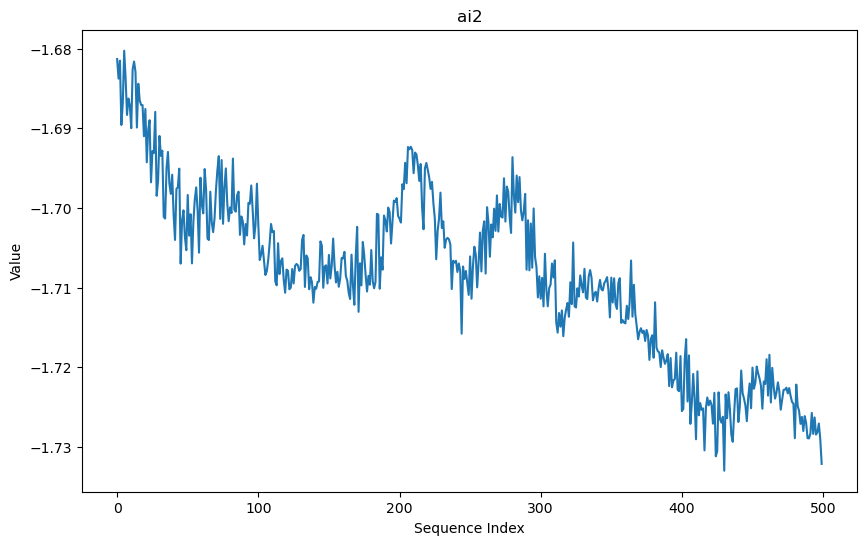

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df["AI2"][20000:20500])
plt.title('Feature AI2')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(AI2[20000:20500])
plt.title('ai2')
plt.xlabel('Sequence Index')
plt.ylabel('Value')
plt.show()

